In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm
%load_ext autoreload
%autoreload 1
#%aimport __pycache__.lddt.cpython-39
%aimport sautils.encoder_commons
%aimport sautils.common
%aimport torch
import pandas as pd
# manual start: pymol/start.sh -R

#import xmlrpc.client as xmlrpclib
#from ssw_lib import CSsw
#from Bio import Align
#from Bio import pairwise2
#from Bio.Seq import Seq 
#from Bio.Align import substitution_matrices
#import Bio
#import optax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sid2seq_ss = {}
with open('data/ss.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_ss[sid] = line
            sid = ''
sid2seq_aa = {}
with open('data/aa.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_aa[sid] = line
            sid = ''
mat3di = np.load('data/mat3di.npy') * 2.1
blosum = np.load('data/blosum62.npy') * 1.4
with open('data/mat3di.out') as f:
    lines = f.readlines()
i2a = lines[3].split()
def seq2num(q):
    idx = []
    for a in q:
        idx.append(i2a.index(a))
    return np.array(idx)
    
def calcS_np(ss1,ss2 ,aa1, aa2,mat3di, blosum):
    ss1 = seq2num(ss1)
    ss2 = seq2num(ss2)
    aa1 = seq2num(aa1)
    aa2 = seq2num(aa2)
    comb_array_ss = np.array(np.meshgrid(ss1, ss2)).T.reshape(-1, 2)
    comb_array_aa = np.array(np.meshgrid(aa1, aa2)).T.reshape(-1, 2)
    S = (mat3di[comb_array_ss[:,0],comb_array_ss[:,1]].reshape(len(ss1),-1)) + blosum[comb_array_aa[:,0],comb_array_aa[:,1]].reshape(len(aa1),-1)
    return S
def distances(q_points_aln, t_points_aln):
    d_mat = cdist(q_points_aln, t_points_aln)
    return d_mat

In [5]:
coord_dir = 'data/pdb/d*'
if not os.path.exists(coord_dir):
    print('Creating cache first.')
    sautils.encoder_commons.init_coords('data/pdb/d*', coord_dir)
sid2coords = {sid: sautils.encoder_commons.read_coords(coord_dir, sid) for sid in sautils.encoder_commons.list_sids(coord_dir)}

In [6]:
def sw_affine(restrict_turns=True, 
             penalize_turns=True,
             batch=True, unroll=2, NINF=-1e30):
    """smith-waterman (local alignment) with affine gap"""
    # rotate matrix for vectorized dynamic-programming  

    def rotate(x):   
        # solution from jake vanderplas (thanks!)
        a,b = x.shape
        ar,br = jnp.arange(a)[::-1,None], jnp.arange(b)[None,:]
        i,j = (br-ar)+(a-1),(ar+br)//2
        n,m = (a+b-1),(a+b)//2
        output = {"x":jnp.full([n,m],NINF).at[i,j].set(x), "o":(jnp.arange(n)+a%2)%2}
        return output, (jnp.full((m,3), NINF), jnp.full((m,3), NINF)), (i,j)

    # fill the scoring matrix
    def sco(x, lengths, gap=0.0, open=0.0, temp=1.0):

        def _soft_maximum(x, axis=None, mask=None):
            def _logsumexp(y):
                y = jnp.maximum(y,NINF)
                if mask is None: return jax.nn.logsumexp(y, axis=axis)
                else: return y.max(axis) + jnp.log(jnp.sum(mask * jnp.exp(y - y.max(axis, keepdims=True)), axis=axis))
            return temp*_logsumexp(x/temp)

        def _cond(cond, true, false):
            return cond*true + (1-cond)*false
        def _pad(x,shape):
            return jnp.pad(x,shape,constant_values=(NINF,NINF))
      
        def _step(prev, sm):
            h2,h1 = prev   # previous two rows of scoring (hij) mtxs

            Align = jnp.pad(h2,[[0,0],[0,1]]) + sm["x"][:,None]
            Right = _cond(sm["o"], _pad(h1[:-1],([1,0],[0,0])),h1)
            Down  = _cond(sm["o"], h1,_pad(h1[1:],([0,1],[0,0])))

            # add gap penalty
            if penalize_turns:
                Right += jnp.stack([open,gap,open])
                Down += jnp.stack([open,open,gap])
            else:
                gap_pen = jnp.stack([open,gap,gap])
                Right += gap_pen
                Down += gap_pen

            if restrict_turns:
                Right = Right[:,:2]

            h0_Align = _soft_maximum(Align,-1)
            h0_Right = _soft_maximum(Right,-1)
            h0_Down = _soft_maximum(Down,-1)
            h0 = jnp.stack([h0_Align, h0_Right, h0_Down], axis=-1)
            return (h1,h0),h0

        # mask
        a,b = x.shape
        real_a, real_b = lengths
        mask = (jnp.arange(a) < real_a)[:,None] * (jnp.arange(b) < real_b)[None,:]
        x = x + NINF * (1 - mask)

        sm, prev, idx = rotate(x[:-1,:-1])
        hij = jax.lax.scan(_step, prev, sm, unroll=unroll)[-1][idx]

        # sink
        return _soft_maximum(hij + x[1:,1:,None], mask=mask[1:,1:,None])

    # traceback to get alignment (aka. get marginals)
    traceback = jax.grad(sco)

    # add batch dimension
    if batch: return jax.vmap(traceback,(0,0,None,None,None))
    else: return traceback, sco
    
def sw(unroll=2, batch=True, NINF=-1e30):
  '''smith-waterman (local alignment) with gap parameter'''

  # rotate matrix for striped dynamic-programming
  def rotate(x):   
    # solution from jake vanderplas (thanks!)
    a,b = x.shape
    ar,br = jnp.arange(a)[::-1,None], jnp.arange(b)[None,:]
    i,j = (br-ar)+(a-1),(ar+br)//2
    n,m = (a+b-1),(a+b)//2
    output = {"x":jnp.full([n,m],NINF).at[i,j].set(x), "o":(jnp.arange(n)+a%2)%2}
    return output, (jnp.full(m, NINF), jnp.full(m, NINF)), (i,j)

  # compute scoring (hij) matrix
  def sco(x, lengths, gap=0, temp=1.0):

    def _soft_maximum(x, axis=None, mask=None):
      def _logsumexp(y):
        y = jnp.maximum(y,NINF)
        if mask is None: return jax.nn.logsumexp(y, axis=axis)
        else: return y.max(axis) + jnp.log(jnp.sum(mask * jnp.exp(y - y.max(axis, keepdims=True)), axis=axis))
      return temp*_logsumexp(x/temp)
    
    def _cond(cond, true, false): return cond*true + (1-cond)*false
    def _pad(x,shape): return jnp.pad(x,shape,constant_values=(NINF,NINF))

    def _step(prev, sm):      
      h2,h1 = prev   # previous two rows of scoring (hij) mtx
      h1_T = _cond(sm["o"],_pad(h1[:-1],[1,0]),_pad(h1[1:],[0,1]))
      
      # directions
      Align = h2 + sm["x"]
      Turn_0 = h1 + gap
      Turn_1 = h1_T + gap
      Sky = sm["x"]

      h0 = jnp.stack([Align, Turn_0, Turn_1, Sky], -1)
      h0 = _soft_maximum(h0, -1)
      return (h1,h0),h0

    # mask
    a,b = x.shape
    real_a, real_b = lengths
    mask = (jnp.arange(a) < real_a)[:,None] * (jnp.arange(b) < real_b)[None,:]
    x = x + NINF * (1 - mask)

    sm, prev, idx = rotate(x[:-1,:-1])
    hij = jax.lax.scan(_step, prev, sm, unroll=unroll)[-1][idx]
    return _soft_maximum(hij + x[1:,1:], mask=mask[1:,1:])

  # traceback (aka backprop) to get alignment
  traceback = jax.grad(sco)

  # add batch dimension
  if batch: return jax.vmap(traceback,(0,0,None,None))
  else: return traceback


fused_model = torch.load('data/distance_model_integrated_1.torch')

w_list = [fused_model[i].weight.detach().numpy() for i in [0, 2, 4, 6, 8]]
bias_list = [fused_model[i].bias.detach().numpy() for i in [0, 2, 4, 6, 8]]



def lol_score_jax(d_ij, d_kl, d_seq):    
    x = jnp.stack(
        [jnp.log(d_ij/d_kl),
         jnp.log(d_ij),
         jnp.log(d_kl),
         jnp.sign(d_seq) * jnp.log(1 + jnp.abs(d_seq)),
        ],
        axis=-1)
    # NN
    for w, bias in zip(w_list[:-1], bias_list[:-1]):
        x = jax.nn.relu((x @ w.T) + bias)
    x = (x @ w_list[-1].T) + bias_list[-1]  # last layer has no ReLU
    p = jax.nn.sigmoid(x)
    # Probabilities to log odd scores
    score = jnp.log(p / (1-p)).reshape(-1)
    return score

404
196


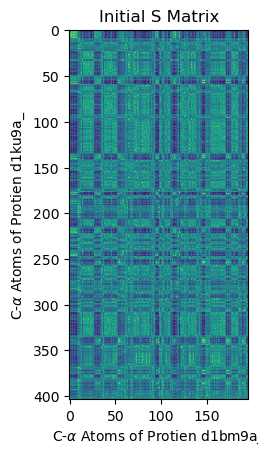

In [7]:
query = 'd1dkza1'
target = 'd2p06a1'
query, target = "d1ufaa2", "d2c1ia1"
#query, target = 'd1nrwa' ,'d2hi0a'
#query, target = "d1bm9a_", "d1ku9a_"
#query, target = "d1ec7a1", "d1hjua_"
#query, target = "d1smoa_", "d2nxyb1"
#query, target = "d2oula_", "d2cb5a_" 
#query, target = "d1lucb_" ,"d1rd5a_"

qt_swap = False
if len(sid2seq_aa[query]) >= len(sid2seq_aa[target]):
    #query, target = target, query
    qt_swap = True

aa1 = sid2seq_aa[query]
aa2 = sid2seq_aa[target]
ss1 = sid2seq_ss[query]
ss2 = sid2seq_ss[target]
S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
print(len(aa1))
print(len(aa2))
im = plt.imshow(S)
plt.xlabel(r'C-$\alpha$ Atoms of Protien d1bm9a_')
plt.ylabel(r'C-$\alpha$ Atoms of Protien d1ku9a_')
plt.title("Initial S Matrix")
#plt.colorbar(im)
plt.show()
example_alignment = {'query': query,
                     'target': target,
                     'cigar': '10M6I6M1D12M3I2M1I4M2I8M1I6M3I10M9I21M23I2M2D9M7I27M2D48M3D1M1D5M',
                     'qstart': 6,
                     'tstart': 4}
coords1,_ = sid2coords.get(example_alignment['query'])
coords2,_ = sid2coords.get(example_alignment['target'])
coords1 = coords1[:,:3]
coords2 = coords2[:,:3]
d_mat_ij = distances(coords1, coords1)
d_mat_ij[d_mat_ij > 15] = 0
d_mat_kl = distances(coords2, coords2)
d_mat_ij = np.asarray(d_mat_ij)
d_mat_kl = np.asarray(d_mat_kl)

In [8]:
d_mat_ij.shape

(404, 404)

In [9]:
from enum import IntEnum
import numpy as np

# Assigning the constants for the scores
class Score(IntEnum):
    GAP = -40

# Assigning the constant values for the traceback
class Trace(IntEnum):
    STOP = 0
    LEFT = 1 
    UP = 2
    DIAGONAL = 3

# Reading the fasta file and keeping the formatted sequence's name and sequence
def fasta_reader(sequence_file):
    lines = open(sequence_file).readlines()
    sequence_name_row = lines[0][1:]
    sequence = lines[1]
    return sequence_name_row.replace(" ", "").strip(), sequence.strip()

# Implementing the Smith Waterman local alignment
def smith_waterman(seq1, seq2,S):
    # Generating the empty matrices for storing scores and tracing
    row = len(seq1) + 1
    col = len(seq2) + 1
    matrix = np.zeros(shape=(row, col), dtype='int16')  
    tracing_matrix = np.zeros(shape=(row, col), dtype='int16')  
    
    # Initialising the variables to find the highest scoring cell
    max_score = -1
    max_index = (-1, -1)
    
    # Calculating the scores for all cells in the matrix
    for i in range(1, row):
        for j in range(1, col):
            # Calculating the diagonal score (match score)
            #match_value = Score.MATCH if seq1[i - 1] == seq2[j - 1] else Score.MISMATCH
            s = np.array([0, 
                          matrix[i - 1, j] + Score.GAP, 
                          matrix[i, j - 1] + Score.GAP,
                          matrix[i - 1, j - 1] + S[i-1,j-1]])
            matrix[i, j] = np.max(s)
            tracing_matrix[i,j] = np.argmax(s)

            if matrix[i, j] >= max_score:
                max_index = (i,j)
                max_score = matrix[i, j]

    
    # Initialising the variables for tracing
    aligned_seq1 = ""
    aligned_seq2 = "" 
    current_aligned_seq1 = ""   
    current_aligned_seq2 = ""  
    (max_i, max_j) = max_index
    alig_mat = np.zeros_like(matrix)
    anchor_points = []
    #anchor_points = [[max_i, max_j]]
    
    
    # Tracing and computing the pathway with the local alignment
    while tracing_matrix[max_i, max_j] != Trace.STOP:
        if tracing_matrix[max_i, max_j] == Trace.DIAGONAL:
            alig_mat[max_i - 1, max_j - 1] = 1
            
            current_aligned_seq1 = seq1[max_i - 1]
            current_aligned_seq2 = seq2[max_j - 1]
            max_i = max_i - 1
            max_j = max_j - 1
            anchor_points.append([max_i, max_j])
            
        elif tracing_matrix[max_i, max_j] == Trace.UP:
            break
            current_aligned_seq1 = seq1[max_i - 1]
            current_aligned_seq2 = '-'
            max_i = max_i - 1    
            
        elif tracing_matrix[max_i, max_j] == Trace.LEFT:
            break
            current_aligned_seq1 = '-'
            current_aligned_seq2 = seq2[max_j - 1]
            max_j = max_j - 1
            
        aligned_seq1 = aligned_seq1 + current_aligned_seq1
        aligned_seq2 = aligned_seq2 + current_aligned_seq2
    
    # Reversing the order of the sequences
    aligned_seq1 = aligned_seq1[::-1]
    aligned_seq2 = aligned_seq2[::-1]
    matrix = np.delete(np.delete(matrix, 0, axis = 0), 0, axis=1)
    tracing_matrix = np.delete(np.delete(tracing_matrix, 0, axis = 0), 0, axis=1)
    alig_mat = np.delete(np.delete(alig_mat, 0, axis = 0), 0, axis=1)
    
    return aligned_seq1, aligned_seq2, matrix, tracing_matrix, alig_mat, np.array(anchor_points)

In [10]:
def calc_startAnchor(aa1, aa2, S, num):
    all_anchor_points = []
    S = np.array(S)
    for i in range(num):
        smith_waterman(aa1,aa2,S)
        a,b,m,tm, alig_mat, anchor_points = smith_waterman(aa1,aa2,S)
        all_anchor_points.append(anchor_points)
        S[anchor_points[:,0], anchor_points[:,1]] = - 1e6
    return all_anchor_points

In [11]:
def fix_anch(S, anchor_points, th, temp, d_mat_ij, d_mat_kl):
    W = 16
    start = time.time()
    sw_app = sw(batch=False)
    S = S.at[anchor_points[:,0], anchor_points[:,1]].set(1e6)
    P = sw_app(S,S.shape, gap=-5, temp=temp)
    #print(time.time() - start)
    start = time.time()
    
    
    anchor_points = np.argwhere(P >= th)
    S = S.at[anchor_points[:,0], anchor_points[:,1]].set(1e6)
    P = sw_app(S,S.shape, gap=-5, temp=temp)
    



    
    idx_ij = np.swapaxes(np.array(np.indices(d_mat_ij.shape)).T,0,1)
    #d_mask_ij = np.asarray(d_mat_ij > 0)
    #idx_ij = idx_ij[d_mat_ij > 0]
    #idx_ij = idx_ij.reshape(-1,2)
    idx_kl = np.swapaxes(np.array(np.indices(d_mat_kl.shape)).T,0,1)
    idx_kl = idx_kl.reshape(-1,2)
    
    #print(time.time() - start)
    start = time.time()


    anch_idx_ij = idx_ij[np.isin(idx_ij[:,0], anchor_points[:,0])[:,0]].reshape(-1,2)
    idx_ijk = np.zeros((anch_idx_ij.shape[0],3), dtype='int16')
    #print(idx_ijk.shape, anchor_points.shape, S.shape)
    idx_ijk[:,:2] = anch_idx_ij
    idx_ijk[:,2] = np.repeat(anchor_points[:,1],S.shape[0]).reshape(-1)
    #idx_ijk[:,2] = np.array([anchor_points[(anchor_points[:, 0] == idx_ijk[i, 0]), 1] for i in range(idx_ijk.shape[0])]).reshape(-1)
    
    start = time.time()
    
    idx_ijkl = np.zeros((idx_ijk.shape[0]* W, 4), dtype ="int16")
    
    P_W_idx = jnp.sort(jnp.argpartition(P, -W, axis = 1)[:,-W:])
    
    idx_ijkl[:,:3] = np.repeat(idx_ijk, W, axis = 0).reshape(-1,3)
    
    idx_ijkl[:,3] = np.repeat(P_W_idx.reshape(-1,1),anchor_points.shape[0], axis = 1).T.reshape(-1)
    
    idx_ijkl = idx_ijkl[d_mat_ij[idx_ijkl[:,0],idx_ijkl[:,1]] <= 15]    
    
    start = time.time()

    idx_ijkl = idx_ijkl[np.isin(idx_ijkl[:,1], anchor_points[:,0],  invert=True),:]
    idx_ijkl = idx_ijkl[np.isin(idx_ijkl[:,3], anchor_points[:,1],  invert=True),:]
    
    start = time.time()
    
    #alpha = np.ones_like(dist_ijkl.shape[0])
    #alpha = np.where(np.subtract(idx_ijkl[:,0],idx_ijkl[:,1]) == np.subtract(idx_ijkl[:,3],idx_ijkl[:,2]), 0.5*alpha, alpha)
    #alpha = np.where(idx_ijkl[:,2] == idx_ijkl[:,3], 0*alpha, alpha)
    return S, jnp.array(d_mat_ij[idx_ijkl[:,0],idx_ijkl[:,1]]), jnp.array(d_mat_kl[idx_ijkl[:,2],idx_ijkl[:,3]]), jnp.array((idx_ijkl[:,3] - idx_ijkl[:,2])),jnp.array(idx_ijkl.T), jnp.array(anchor_points), 1#alpha

In [10]:
S = jnp.array(S)
fix_anch(S, anchor_points, th, temp)[1].shape


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


NameError: name 'anchor_points' is not defined

In [12]:
@jax.jit

def lol_score_anchor(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, temp):
    sw_app = sw(batch=False)
    P = sw_app(S,S.shape, gap=-5, temp=temp)
    G_mat = jnp.nan_to_num(lol_score_jax(dist_ij,
                                         dist_kl, 
                                         index_diff))

    
    P_jl = P[idx_ijkl[1,:], idx_ijkl[3,:]]
    lol_score = jnp.dot(G_mat,(P_jl + 10e-12))#**alpha)
    return -lol_score

In [13]:
@jax.jit
def step(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, opt_state, temp):
    #G, P, P_idx_ik, P_idx_jl, alpha = update_gkl_jit(P, S)
    lol_score, grad = jax.value_and_grad(lol_score_anchor)(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, temp)
    updates, opt_state = optimizer.update(grad, opt_state)
    S = optax.apply_updates(S, updates)
    return S, opt_state, lol_score

In [38]:
startAnchor = calc_startAnchor(aa1, aa2, S, 10)


KeyboardInterrupt: 

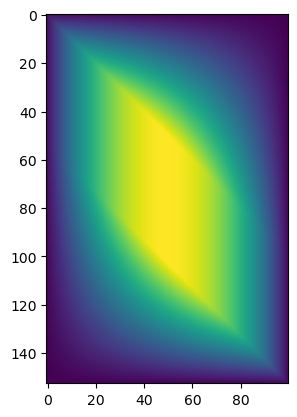

In [33]:
P = sw_app(np.zeros_like(S),S.shape, gap=-10, temp=1)
plt.imshow(P)

In [41]:
startAnchor

[array([[41, 50],
        [40, 49],
        [39, 48],
        [38, 47],
        [37, 46],
        [36, 45],
        [35, 44],
        [34, 43],
        [33, 42],
        [32, 41],
        [31, 40],
        [30, 39],
        [29, 38],
        [28, 37],
        [27, 36],
        [26, 35],
        [25, 34],
        [24, 33],
        [23, 32],
        [22, 31],
        [21, 30],
        [20, 29]]),
 array([[206, 163],
        [205, 162],
        [204, 161],
        [203, 160],
        [202, 159],
        [201, 158],
        [200, 157],
        [199, 156],
        [198, 155],
        [197, 154],
        [196, 153],
        [195, 152],
        [194, 151],
        [193, 150],
        [192, 149],
        [191, 148],
        [190, 147],
        [189, 146],
        [188, 145],
        [187, 144]]),
 array([[192, 147],
        [191, 146],
        [190, 145],
        [189, 144],
        [188, 143],
        [187, 142],
        [186, 141],
        [185, 140],
        [184, 139],
        [183, 138],


In [57]:
%%time
th = 0.999
all_S = []
#startAnchor = calc_startAnchor(aa1, aa2, S, 10)
for j in tqdm(range(10)):
    #print("test")
    S = jnp.array(calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum))
    S = S.at[startAnchor[j][:,0], startAnchor[j][:,1]].set(1e6)
    #print("test")
    
    th = .999
    temp = 10
    S = jnp.array(S)
    optimizer = optax.adagrad(1e0)
    opt_state = optimizer.init(S)
    sw_app = sw(batch=False)
    lol_score = 0
    anchor_points = startAnchor[9]
    t = time.time()
    for i in (range(500)):
        if i%100 == 0:
            #print(time.time() - t)
            S, dist_ij, dist_kl, index_diff, idx_ijkl, anchor_points, alpha = fix_anch(S, anchor_points, th, temp, d_mat_ij, d_mat_kl)
            th -= 0.1
            t = time.time()
            
        #lol_score, grad = jax.value_and_grad(lol_score_anchor)(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, temp)
        S, opt_state, lol_score = step(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, opt_state, temp)
        #S += grad 
        #updates, opt_state = optimizer.update(grad, opt_state)
        #S = optax.apply_updates(S, updates)
        #print(lol_score)

    all_S.append(S)


100%|███████████████████████████████████████████| 10/10 [04:24<00:00, 26.43s/it]

CPU times: user 5min 2s, sys: 9.56 s, total: 5min 12s
Wall time: 4min 24s


In [18]:
alignments = pd.read_csv("benchmark/alignments.csv", sep=',')
alignments

,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,q_scope,t_scope,same_fam,same_sfam,same_fold,qstart_dali,tstart_dali,cigar_dali,dali_rank
0,d12asa_,d12asa_,2924,1.0000,327M,1,1,327,d.104.1.1,d.104.1.1,True,True,True,1,1,327M,1
1,d12asa_,d1nnha_,392,0.5557,18M3D11M4I6M5D14M3I19M4I15M1D46M8I4M1D16M1I3M4...,7,11,317,d.104.1.1,d.104.1.1,True,True,True,1,9,23M1I12M4I7M5D9M3I20M1I4M3I10M1I4M2D18M7I47M6I...,2
2,d12asa_,d1b8aa2,389,0.5209,20M3D10M4I5M2I12M3I20M4I13M1I24M1D33M3D4M2I15M...,5,29,342,d.104.1.1,d.104.1.1,True,True,True,1,29,23M1I13M3I4M3I9M3I19M1I4M3I12M1I21M6I27M7D4M1D...,3
3,d12asa_,d1eova2,342,0.5274,21M3D10M5I9M1I8M3I20M4I12M1I27M2I15M7D15M1D3M2...,5,39,340,d.104.1.1,d.104.1.1,True,True,True,1,34,4M1D21M3D12M6I13M3I24M4I12M1I21M2I28M1D4M5D6M4...,5
4,d12asa_,d1l0wa3,277,0.4977,20M3D10M7I39M4I13M1I3M1I19M4I15M6I13M2I23M6I1M...,5,35,330,d.104.1.1,d.104.1.1,True,True,True,1,35,23M1I14M7I37M4I18M2I14M7I23M5I20M5I4M2I4M3D8M1...,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362993,d8abpa_,d1zgha2,49,0.3744,6M3I4M3I10M2D10M2I5M2I15M4I13M1I10M,3,2,90,c.93.1.1,c.65.1.1,False,False,False,2,1,9M3I15M1I10M5I6M1D12M1D4M5I9M1I7M4D7M21D17M115...,391
362994,d8abpa_,d7reqa2,49,0.4523,6M2D10M4I16M2D4M4I20M3D15M3D8M,1,37,97,c.93.1.1,c.23.6.1,False,False,False,1,37,8M2D4M3I14M1I11M2I21M2D5M1D9M3D12M1I10M3D6M146...,78
362995,d8abpa_,d2q46a_,49,0.3542,12M1I12M1I3M3I4M1D8M13D11M2D9M25D4M1D2M4D13M1D...,1,3,177,c.93.1.1,c.2.1.2,False,False,False,1,4,11M2I12M1I4M1I9M13D6M3D7M2I10M29D4M1D13M1D6M21...,180
362996,d8abpa_,d2e7ja_,49,0.3734,15M10I9M4I2M3I13M3I8M1D17M3D9M2D5M3D15M3I5M5I1...,109,51,160,c.93.1.1,c.67.1.9,False,False,False,82,1,4M17I4M37D18M6I11M8I14M3I7M5D4M4I10M1D13M7D14M...,388


In [20]:
alignments_t

,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,q_scope,t_scope,same_fam,same_sfam,same_fold,qstart_dali,tstart_dali,cigar_dali,dali_rank


In [17]:
query, target = "d2v33a_", "d1r17a2"

alignments_q = alignments.loc[alignments['query'] == query]
alignments_t = alignments_q.loc[alignments['target'] == target]
example_alignment = {'query': query,
                     'target': target,
                     'cigar': alignments_t["cigar_dali"].values[0],
                     'qstart': alignments_t["qstart_dali"].values[0],
                     'tstart': alignments_t["tstart_dali"].values[0]}

def distances_ij(q_points_aln, t_points_aln, cutoff=15):
    """intra-molecular distances with cutoff"""
    d_ij = np.sqrt(np.sum((q_points_aln[:, None] - q_points_aln[None, :])**2, axis=-1))
    d_kl = np.sqrt(np.sum((t_points_aln[:, None] - t_points_aln[None, :])**2, axis=-1))

    neighbor_mask = (d_ij < cutoff).astype(np.float32) * (1. - np.eye(len(d_ij)))
    return (neighbor_mask * d_ij, neighbor_mask * d_kl)

def align_coords(query, target, alignment):
    coords1, mask1 = query
    coords2, mask2 = target
    cigar, q_start, t_start = alignment

    idx1, idx2 = sautils.common.parse_cigar(cigar, query=q_start, ref=t_start, include_m=True, order_qt=True).T

    # Remove masked residues from alignment
    mask = mask1[idx1] & mask2[idx2]
    aln_coords1 = coords1[idx1, :3][mask]  # need only CA
    aln_coords2 = coords2[idx2, :3][mask]    
    return (aln_coords1, aln_coords2), (idx1, idx2), (len(coords1), len(coords2))

# Load coordinates and alignment
coords1, mask1 = sid2coords.get(example_alignment['query'])
coords2, mask2 = sid2coords.get(example_alignment['target'])    
(aln_coords1, aln_coords2), (idx1, idx2), (len1, len2) =\
        align_coords((coords1, mask1),
                     (coords2, mask2),
                     (example_alignment['cigar'], example_alignment['qstart'], example_alignment['tstart']))    
# Distance and sequence distance mats.
# Intra-molecular distances between *aligned* resdiues of query and target.
d_mat_ij, d_mat_kl = distances_ij(aln_coords1, aln_coords2, cutoff=15)
# Sequence distance between *aligned* query residues
d_mat_seq = idx1[None, :] - idx1[:, None]
# Distances beyond 15A are masked with zeros. (Invalid residues were not in the alingment)
d_mask = d_mat_ij > 0

d_ij, d_kl, d_seq = d_mat_ij[d_mask], d_mat_kl[d_mask], d_mat_seq[d_mask]
_lol_scores = lol_score_jax(d_ij, d_kl, d_seq)
print(np.sum(_lol_scores))

aa1 = sid2seq_aa[query]
aa2 = sid2seq_aa[target]
ss1 = sid2seq_ss[query]
ss2 = sid2seq_ss[target]
S = calcS_np(ss1,ss2 ,aa1, aa2,mat3di, blosum)
dali = np.zeros_like(S)
dali[idx1,idx2] = 1
#dali[startAnchor[0][:,0], startAnchor[0][:,1]] = 2
plt.imshow(dali)
plt.title("Dali")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
lol_dali = []
for query,target in zip(querys, targets):
    alignments_q = alignments.loc[alignments['query'] == query]
    alignments_t = alignments_q.loc[alignments['target'] == target]
    example_alignment = {'query': query,
                         'target': target,
                         'cigar': alignments_t["cigar_dali"].values[0],
                         'qstart': alignments_t["qstart_dali"].values[0],
                         'tstart': alignments_t["tstart_dali"].values[0]}
    # Load coordinates and alignment
    coords1, mask1 = sid2coords.get(example_alignment['query'])
    coords2, mask2 = sid2coords.get(example_alignment['target'])    
    (aln_coords1, aln_coords2), (idx1, idx2), (len1, len2) =\
            align_coords((coords1, mask1),
                         (coords2, mask2),
                         (example_alignment['cigar'], example_alignment['qstart'], example_alignment['tstart']))    
    # Distance and sequence distance mats.
    # Intra-molecular distances between *aligned* resdiues of query and target.
    d_mat_ij, d_mat_kl = distances_ij(aln_coords1, aln_coords2, cutoff=15)
    # Sequence distance between *aligned* query residues
    d_mat_seq = idx1[None, :] - idx1[:, None]
    # Distances beyond 15A are masked with zeros. (Invalid residues were not in the alingment)
    d_mask = d_mat_ij > 0

    d_ij, d_kl, d_seq = d_mat_ij[d_mask], d_mat_kl[d_mask], d_mat_seq[d_mask]
    _lol_scores = lol_score_jax(d_ij, d_kl, d_seq)
    print(query, target, np.sum(_lol_scores))
    lol_dali.append(np.sum(_lol_scores))
lol_dali = np.array(lol_dali)

d1bd0a2 d1ykwa1 2347.1333
d1bm9a_ d1ku9a_ -519.67175
d1c4oa1 d1oywa2 7248.0605
d1dkza1 d2p06a1 -226.22137
d1dvoa_ d1s35a1 415.4751
d1ec7a1 d1hjua_ 4470.5107
d1eyva_ d1tzva_ 3539.3599
d1f1sa2 d2omzb_ 827.30054
d1g1ca_ d1cs6a1 2690.0017
d1h6ka2 d3gvoa_ 811.7139
d1i16a_ d2fcfa1 1560.1797
d1iq0a3 d3eera_ 407.3663
d1jgsa_ d2pg4a1 1241.0623
d1jnra1 d1oe8a1 270.7372
d1ktba1 d1wzaa1 1209.0627
d1kv9a1 d1gu2a_ 692.64594
d1ky8a_ d1duvg1 1896.2644
d1lucb_ d1rd5a_ 6027.9463
d1m70a1 d3cu4a_ 804.15063
d1mkya2 d1n0ua2 4584.0566
d1n7ka_ d3qz6a_ 3805.0571
d1ncna_ d1fltx_ 2001.4116
d1ncua_ d1gl4b_ 1797.4565
d1nj8a1 d1vi2a2 1093.11
d1nkva_ d1nv8a_ 4079.163
d1oaaa_ d2z1na_ 8194.141
d1omra_ d1auib_ 1625.4915
d1oz2a2 d3hl8a_ 745.3557
d1p99a_ d2nxoa1 5525.079
d1piia1 d3igsa_ 3522.9004
d1plqa2 d1ud9a2 3687.3882
d1pm4a_ d1olma2 1239.6506
d1ppjd1 d1c52a_ 1214.3574
d1q1fa_ d1b0ba_ 3039.9873
d1q1ha_ d1q1ha_ 2714.0964
d1q5da_ d3awma_ 17804.19
d1qhxa_ d1knqa_ 4173.9404
d1qmha2 d1nj8a2 582.44543
d1quua2 d1quua1 2156.

In [26]:
lol_dali[37], np.max(all_lolscores_ij[:,37])
alignments["query"]

(582.44543, 733.1575927734375)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  1.,  0.,  2.,  2.,  0.,  1.,  1.,  0.,  2.,  1.,
         0.,  1.,  2.,  3.,  7.,  3.,  2.,  8., 13., 20., 10.,  2.,  2.,
         1.,  2.,  0.,  6.,  2.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-3247.47070312, -3155.43874146, -3063.40677979, -2971.37481812,
        -2879.34285645, -2787.31089478, -2695.27893311, -2603.24697144,
        -2511.21500977, -2419.1830481 , -2327.15108643, -2235.11912476,
        -2143.08716309, -2051.05520142, -1959.02323975, -1866.99127808,
        -1774.95931641, -1682.92735474, -1590.89539307, -1498.8634314 ,
        -1406.83146973, -1314.79950806, -1222.76754639, -1130.73558472,
        -1038.70362305,  -946.67166138,  -854.63969971,  -762.60773804,
         -670.57577637,  -578.5438147 ,  -486.51185303,  -394.47989136,
         -302.44792969,  -210.41596802,  -118.38400635,   -26.35204468,
           65.67991699,   157.71187866,   249.74384033,   341.775802

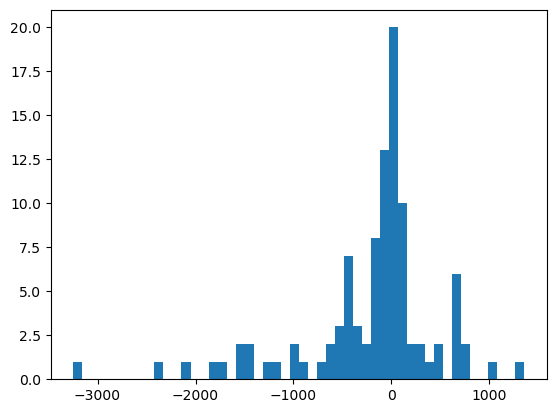

In [30]:
plt.hist((alignments["lolscore_anchor"] - lol_dali), bins=50)

In [31]:
plt.hist((np.max(all_lolscores_ij, axis = 0) - lol_dali), bins=50)

NameError: name 'all_lolscores_ij' is not defined

(array([ 6.,  3., 26., 17., 10.,  7.,  7.,  1.,  3.,  2.,  3.,  1.,  0.,
         1.,  2.,  2.,  1.,  1.,  1.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-201.72949219, -123.05304688,  -44.37660156,   34.29984375,
         112.97628906,  191.65273437,  270.32917969,  349.005625  ,
         427.68207031,  506.35851562,  585.03496094,  663.71140625,
         742.38785156,  821.06429687,  899.74074219,  978.4171875 ,
        1057.09363281, 1135.77007812, 1214.44652344, 1293.12296875,
        1371.79941406, 1450.47585937, 1529.15230469, 1607.82875   ,
        1686.50519531, 1765.18164062, 1843.85808594, 1922.53453125,
        2001.21097656, 2079.88742187, 2158.56386719, 2237.2403125 ,
        2315.91675781, 2394.59320312, 2473.26964844, 2551.94609375,
        2630.62253906, 2709.29898437, 2787.97542969, 2866.651875  ,
        2945.32832031, 3024.00476562

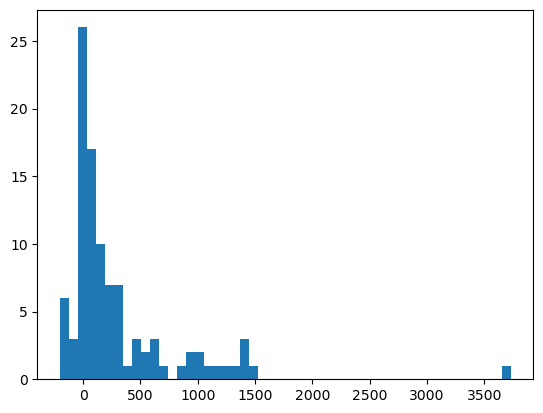

In [18]:
plt.hist((np.max(all_lolscores_kl, axis = 0) - lol_dali), bins=50)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  8., 14., 14.,
        19.,  9.,  7.,  5.,  3.,  4.,  1.,  4.,  2.,  3.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-716.1328125 , -686.12532227, -656.11783203, -626.1103418 ,
        -596.10285156, -566.09536133, -536.08787109, -506.08038086,
        -476.07289063, -446.06540039, -416.05791016, -386.05041992,
        -356.04292969, -326.03543945, -296.02794922, -266.02045898,
        -236.01296875, -206.00547852, -175.99798828, -145.99049805,
        -115.98300781,  -85.97551758,  -55.96802734,  -25.96053711,
           4.04695312,   34.05444336,   64.06193359,   94.06942383,
         124.07691406,  154.0844043 ,  184.09189453,  214.09938477,
         244.106875  ,  274.11436523,  304.12185547,  334.1293457 ,
         364.13683594,  394.14432617,  424.15181641,  454.15930664,
         484.16679687,  514.17428711

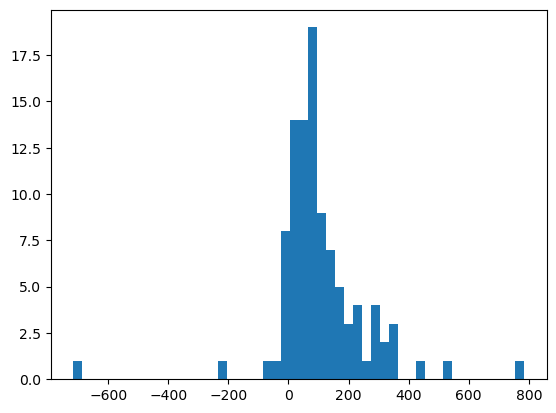

In [22]:
plt.hist((np.max(all_lolscores_ij, axis = 0) - np.max(all_lolscores_kl, axis = 0)), bins=50)

array([2154.30908203,  648.59228516,  828.53234863, 1048.27062988,
        660.95001221, 1580.75683594,  223.8462677 , 1714.36767578,
        703.9465332 ,  184.94091797])

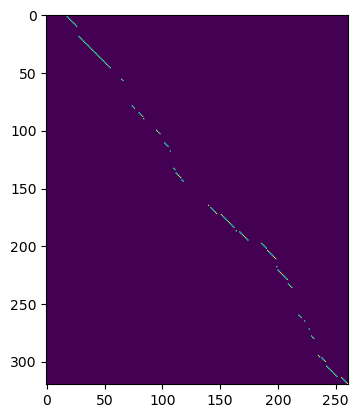

In [82]:
test = np.array(all_S[5])#[startAnchor[3][:,0], startAnchor[3][:,1]]# = 1
#test[startAnchor[3][:,0], startAnchor[3][:,1]] = 0
#test.shape
P = sw_app(all_S[0],S.shape, gap=-5, temp=temp)
P = np.array(P)
#P[startAnchor[0][:,0], startAnchor[0][:,1]] = 2
plt.imshow(all_S[0])
all_lolscores[:,17]

In [22]:
aa1 = sid2seq_aa[query]
aa2 = sid2seq_aa[target]
ss1 = sid2seq_ss[query]
ss2 = sid2seq_ss[target]
#S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum) 
coords1,_ = sid2coords.get(query)
coords2,_ = sid2coords.get(target)
coords1 = coords1[:,:3]
coords2 = coords2[:,:3]
d_mat_ij = distances(coords1, coords1)
d_mat_ij[d_mat_ij > 15] = 0
d_mat_kl = distances(coords2, coords2)
d_mat_ij = np.asarray(d_mat_ij)
d_mat_kl = np.asarray(d_mat_kl)
for i in range(10):

    S = all_S[i]
    
    P = sw_app(S,S.shape, gap=-5, temp=temp)
    #P = dali
    th = .5
    index_test = (np.argwhere(np.sum(P > th,axis = 0) != 0).reshape(-1)[None,:] - np.argwhere(np.sum(P > th,axis = 0) != 0).reshape(-1)[:,None])

    
    index_temp = np.argwhere(np.sum(P > th,axis = 1) == 0)
    d_mat_ij_test = np.delete(d_mat_ij, index_temp, axis = 0)
    d_mat_ij_test = np.delete(d_mat_ij_test, index_temp, axis = 1)

    index_temp = np.argwhere(np.sum(P > th,axis = 0) == 0)

    d_mat_kl_test = np.delete(d_mat_kl, index_temp, axis = 0)
    d_mat_kl_test = np.delete(d_mat_kl_test, index_temp, axis = 1)

    d_mask_test = d_mat_ij_test > 0

    d_ij_test, d_kl_test, d_seq_test = d_mat_ij_test[d_mask_test], d_mat_kl_test[d_mask_test], index_test[d_mask_test]
    _lol_scores = lol_score_jax(d_ij_test, d_kl_test, d_seq_test)
    print(np.sum(_lol_scores))

7627.545
8184.115
8460.667
7551.7695
9335.164
9715.119
4855.349
1413.1267
1794.8411
7551.7695


In [17]:
posi = 90
for query,target in zip(querys[posi+1:], targets[posi+1:]):
    lol_score =  0
    posi +=1
    aa1 = sid2seq_aa[query]
    aa2 = sid2seq_aa[target]
    ss1 = sid2seq_ss[query]
    ss2 = sid2seq_ss[target]
    S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum) -1
    coords1,_ = sid2coords.get(query)
    coords2,_ = sid2coords.get(target)
    coords1 = coords1[:,:3]
    coords2 = coords2[:,:3]
    d_mat_ij = distances(coords1, coords1)
    #d_mat_ij[d_mat_ij > 15] = 0
    d_mat_kl = distances(coords2, coords2)
    d_mat_ij = np.asarray(d_mat_ij)
    d_mat_kl = np.asarray(d_mat_kl)
    print(d_mat_ij.shape, d_mat_kl.shape)
    #a,b,m,tm, alig_mat, anchor_points = smith_waterman(aa1,aa2,S)
    temp = 10
    
    optimizer = optax.adagrad(1e0)
    opt_state = optimizer.init(S)
    sw_app = sw(batch=False)
    startAnchor = calc_startAnchor(aa1, aa2, S, 10)
    #step_jit = jax.jit(step)
    #lol_score_anchor_jit = jax.jit(lol_score_anchor)
    for j in range(10):
        anchor_points = startAnchor[j]
        d_mat_ij = distances(coords1, coords1)
        d_mat_kl = distances(coords2, coords2)
        d_mat_ij = np.asarray(d_mat_ij)
        d_mat_kl = np.asarray(d_mat_kl)
        th = .999
        S = jnp.array(calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum))
        for i in (range(500)):
            if i%100 == 0:
                S, dist_ij, dist_kl, index_diff, idx_ijkl, anchor_points, alpha = fix_anch(S, anchor_points, th, temp, d_mat_ij, d_mat_kl)
                th -= 0.1
                print(posi, i, j,anchor_points.shape)
            S, opt_state, lol_score = step(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, opt_state, temp)
            #lol_score, grad = jax.value_and_grad(lol_score_anchor_jit)(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, temp)
            #updates, opt_state = optimizer.update(grad, opt_state)
            #S = optax.apply_updates(S, updates)
            #S, opt_state, lol_score = step_jit(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, opt_state, temp)
        np.save("data/100ScoresFastAnchor_fixed/"+query+"-"+target+"-"+str(j)+".npy", S)

(117, 117) (133, 133)
91 0 0 (12, 2)
91 100 0 (32, 2)
91 200 0 (92, 2)
91 300 0 (101, 2)
91 400 0 (108, 2)
91 0 1 (42, 2)
91 100 1 (52, 2)
91 200 1 (85, 2)
91 300 1 (100, 2)
91 400 1 (106, 2)
91 0 2 (26, 2)
91 100 2 (33, 2)
91 200 2 (65, 2)
91 300 2 (88, 2)
91 400 2 (101, 2)
91 0 3 (21, 2)
91 100 3 (21, 2)
91 200 3 (47, 2)
91 300 3 (59, 2)
91 400 3 (69, 2)
91 0 4 (20, 2)
91 100 4 (22, 2)
91 200 4 (56, 2)
91 300 4 (79, 2)
91 400 4 (99, 2)
91 0 5 (40, 2)
91 100 5 (48, 2)
91 200 5 (75, 2)
91 300 5 (93, 2)
91 400 5 (101, 2)
91 0 6 (9, 2)
91 100 6 (10, 2)
91 200 6 (25, 2)
91 300 6 (43, 2)
91 400 6 (49, 2)
91 0 7 (11, 2)
91 100 7 (11, 2)
91 200 7 (14, 2)
91 300 7 (22, 2)
91 400 7 (39, 2)
91 0 8 (6, 2)
91 100 8 (7, 2)
91 200 8 (11, 2)
91 300 8 (20, 2)
91 400 8 (31, 2)
91 0 9 (24, 2)
91 100 9 (26, 2)
91 200 9 (46, 2)
91 300 9 (73, 2)
91 400 9 (93, 2)
(331, 331) (354, 354)
92 0 0 (23, 2)
92 100 0 (36, 2)
92 200 0 (131, 2)
92 300 0 (200, 2)
92 400 0 (243, 2)
92 0 1 (31, 2)
92 100 1 (35, 2)
92 20

In [13]:
alignments = pd.read_csv("benchmark/sample_alignments.csv")
querys = alignments["query"]
targets = alignments["target"]


In [18]:
%%time
th = .999
temp = 10
S = jnp.array(S)
optimizer = optax.adagrad(1e0)
opt_state = optimizer.init(S)
sw_app = sw(batch=False)
lol_score = 0
t=0
#step_jit = jax.jit(step)
for i in (range(500)):
    if i%100 == 0:
        #t = time.time()
        #print(time.time() - t)
        S, dist_ij, dist_kl, index_diff, idx_ijkl, anchor_points, alpha = fix_anch(S, anchor_points, th, temp)
        print(anchor_points.shape)
        print(lol_score)
        #print(dist_ikjl, idx_ijkl, alig_mat, fixed, alpha)
        #print(time.time()-t)
        th -= 0.1
        #temp -= 0.1
        t = time.time()
    S, opt_state, lol_score = step(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, opt_state, temp)
    
    #lol_score_anchor(S, dist_ikjl, idx_ijkl, alig_mat, fixed, alpha, temp)
    #lol_score, grad = jax.value_and_grad(lol_score_anchor)(S, dist_ij, dist_kl, index_diff, idx_ijkl, alpha, temp)
    #S += grad
    
print(lol_score)

(11, 2)
0
(13, 2)
-25.078064
(35, 2)
-67.17658


KeyboardInterrupt: 

In [ ]:
idx_ijkl.shape

In [ ]:
P = sw_app(S,S.shape, gap=-5, temp=temp)
plt.imshow(P)

,Unnamed: 0,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,q_scope,...,same_fold,qstart_dali,tstart_dali,cigar_dali,dali_rank,lolscore_dali,lolscore_fs,lolscore_lol_fixed,lolscore_lol_lbfgsb,lolscore_lol_lbfgsb_success
0,7185,d1bd0a2,d1ykwa1,61,0.3718,8M2D14M1I14M3D6M10D10M8D27M7D6M2D11M2I11M3D21M...,10,7,246,c.1.6.1,...,True,2,1,29M2D24M2D4M4D5M1I4M14D5M1I15M6D7M3D7M4I12M6I4...,145,2912.069336,1039.918213,2929.961426,3101.256991,True
1,9019,d1bm9a_,d1ku9a_,39,0.4445,8M2I28M5I10M6I19M,41,46,78,a.4.5.7,...,True,1,11,28M2D12M9I26M5I16M13D24M,123,-692.045227,146.618561,560.031433,839.756596,True
2,11243,d1c4oa1,d1oywa2,50,0.4305,15M5I48M2I11M4I2M21I13M1D6M1I4M71I2M8I8M12I7M2...,8,25,328,c.37.1.19,...,True,1,3,4M13D8M2I14M1I46M2I11M25I31M95I6M2D13M7D6M29I9...,9,4486.741699,2997.943848,5632.099609,1889.544731,True
3,19877,d1dkza1,d2p06a1,27,0.5078,10M1D8M6D4M1D41M,31,8,71,a.8.4.1,...,False,16,1,82M,273,-226.221375,-7.789455,252.211395,439.874062,True
4,21931,d1dvoa_,d1s35a1,13,0.3393,13M4D11M2I13M2D17M3I9M17I14M3I10M,39,2,118,a.136.1.1,...,False,1,14,41M51I5M2I5M1D4M13I31M,48,137.838470,-892.626770,-49.812542,331.485053,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,344737,d3irua_,d2w43a_,98,0.4652,13M7D16M13I13M6I9M3I11M8I3M1I9M2I32M1I31M3I25M...,14,2,264,c.108.1.0,...,True,13,1,16M3D7M22D11M48I14M1I7M1I8M1I11M3I13M2D30M3I27...,44,4616.894043,3447.175537,5635.312500,5836.913727,True
96,349671,d3m94a_,d1sc6a3,42,0.3697,13M10I5M1I27M2I18M3I2M2I9M,76,11,92,d.86.1.0,...,False,54,1,4M7I5M5I9M7I4M2I7M2I30M2I18M3I7M,24,1277.434814,682.383057,1455.606812,1478.339325,True
97,349849,d3ma2b_,d1n9wa1,33,0.3625,9M1D11M2I10M1D2M6I8M8I15M6D3M1D3M4D9M,12,9,99,b.40.3.1,...,True,2,1,24M1I5M2I10M5I9M6I4M1I4M1I11M7D5M3I7M11I7M,37,762.580078,102.951736,1207.911133,1017.300759,True
98,359460,d3t0ha_,d2hkja3,123,0.4256,4M4D11M1D16M1I2M12I10M3D5M2D23M11I7M2D12M4D7M1...,12,4,223,d.122.1.1,...,True,12,1,10M1D5M7D19M13I12M5D21M4I11M5I20M5D11M1D9M5D4M...,5,4263.217773,2510.592285,4352.616211,4548.853023,True


In [88]:
j = -1
#all_lolscores_fixed = np.zeros([100])
for query,target in zip(querys, targets):
    #query, target = "d2oula_", "d2cb5a_"     
    lol_score =  0
    aa1 = sid2seq_aa[query]
    aa2 = sid2seq_aa[target]
    ss1 = sid2seq_ss[query]
    ss2 = sid2seq_ss[target]
    S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)# -1
    coords1,_ = sid2coords.get(query)
    coords2,_ = sid2coords.get(target)
    coords1 = coords1[:,:3]
    coords2 = coords2[:,:3]
    d_mat_ij = distances(coords1, coords1)
    d_mat_ij[d_mat_ij > 15] = 0
    d_mat_kl = distances(coords2, coords2)
    d_mat_ij = np.asarray(d_mat_ij)
    d_mat_kl = np.asarray(d_mat_kl)
    
    j+=1

    S = jnp.load("data/100Scores_fixed/"+query+"-"+target+".npy")

    #S = all_S[i]
    P = np.array(sw_app(S,S.shape, gap=-5, temp=temp))
    th = 0.75
    index_test = (np.argwhere(np.sum(P > th,axis = 0) != 0).reshape(-1)[None,:] - np.argwhere(np.sum(P > th,axis = 0) != 0).reshape(-1)[:,None])

    np.sum(np.sum(P > th,axis = 0) == 0)#.shape
    index_temp = np.argwhere(np.sum(P > th,axis = 1) == 0)
    d_mat_ij_test = np.delete(d_mat_ij, index_temp, axis = 0)
    d_mat_ij_test = np.delete(d_mat_ij_test, index_temp, axis = 1)

    index_temp = np.argwhere(np.sum(P > th,axis = 0) == 0)

    d_mat_kl_test = np.delete(d_mat_kl, index_temp, axis = 0)
    d_mat_kl_test = np.delete(d_mat_kl_test, index_temp, axis = 1)

    d_mask_test = d_mat_ij_test > 0

    d_ij_test, d_kl_test, d_seq_test = d_mat_ij_test[d_mask_test], d_mat_kl_test[d_mask_test], index_test[d_mask_test]
    _lol_scores = lol_score_jax(d_ij_test, d_kl_test, d_seq_test)
    #all_lolscores_fixed[j] = np.sum(_lol_scores)
    print(j,np.sum(_lol_scores))

0 2638.7632
1 529.2141
2 3158.5571
3 277.96857
4 19.652294
5 2606.5225
6 3491.2183
7 730.97424
8 2570.414
9 29.25945
10 948.9004
11 478.25372
12 1360.5131
13 469.1427
14 1254.832
15 971.4315
16 1329.2432
17 632.2294
18 538.5744
19 3849.3862
20 5002.0874
21 1788.7065
22 1787.2706
23 81.19465
24 2486.9294
25 7629.901
26 1833.1207
27 1160.4043
28 4295.302
29 4183.7314
30 3516.1782
31 2224.543
32 14.025335
33 1758.7524
34 2714.0964
35 15341.064
36 3650.027
37 419.94867
38 1824.8771
39 5209.657
40 1036.481
41 2609.584
42 490.3894
43 7.9006987
44 708.2664
45 1394.0334
46 2361.364
47 118.02011
48 3142.6472
49 3.204266
50 1082.7803
51 1756.021
52 441.28333
53 150.40666
54 -0.4216075
55 331.111
56 907.2494
57 1853.9061
58 2494.1592
59 1700.6948
60 5186.36
61 3628.5078
62 6300.0225
63 673.5125
64 3219.021
65 4343.0537
66 4408.0757
67 656.05804
68 -28.782686
69 220.75644
70 3137.2852
71 656.1699
72 4613.3794
73 4026.8396
74 1940.494
75 1440.3906
76 820.6806
77 608.9508
78 143.46877
79 2781.7373
8

In [12]:
alignments = pd.read_csv("benchmark/foldseek_top100_querysubset.tsv", sep='\t', header=None)
querys = alignments[0]
targets = alignments[1]
alignments[4] = 0
alignments[5] = 0

In [14]:
%%time
j = -1
alignments = pd.read_csv("benchmark/foldseek_top100_querysubset.tsv", sep='\t', header=None)
querys = alignments[0]
targets = alignments[1]
alignments[4] = 0
alignments[5] = 0

all_lolscores_kl = np.zeros([10,928])
for query,target in zip(querys, targets):
    #query, target = "d2oula_", "d2cb5a_"     
    lol_score =  0
    aa1 = sid2seq_aa[query]
    aa2 = sid2seq_aa[target]
    ss1 = sid2seq_ss[query]
    ss2 = sid2seq_ss[target]
    #S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)# -1
    coords1,_ = sid2coords.get(query)
    coords2,_ = sid2coords.get(target)
    coords1 = coords1[:,:3]
    coords2 = coords2[:,:3]
    d_mat_ij = distances(coords1, coords1)
    d_mat_ij[d_mat_ij > 15] = 0
    d_mat_kl = distances(coords2, coords2)
    d_mat_ij = np.asarray(d_mat_ij)
    d_mat_kl = np.asarray(d_mat_kl)
    sw_app = jax.jit(sw(batch=False))
    
    j+=1
    for i in range(10):
        S = jnp.load("data/100ScoresFB_aprox/"+query+"-"+target+"-"+str(i)+".npy")
        #S = all_S[i]
        P = np.array(sw_app(S,S.shape, gap=-.5, temp=1))
        #d_mat_ij = distances(coords1, coords1)
        #d_mat_ij[d_mat_ij > 15] = 0
        #d_mat_kl = distances(coords2, coords2)
        #d_mat_ij = np.asarray(d_mat_ij)
        #d_mat_kl = np.asarray(d_mat_kl)
        #P = sw_app(all_S[i],S.shape, gap=-5, temp=temp)
        th = 0.5
        index_test = (np.argwhere(np.sum(P > th,axis = 1) != 0).reshape(-1)[None,:] - np.argwhere(np.sum(P > th,axis = 1) != 0).reshape(-1)[:,None])

        index_temp = np.argwhere(np.sum(P > th,axis = 1) == 0)
        d_mat_ij_test = np.delete(d_mat_ij, index_temp, axis = 0)
        d_mat_ij_test = np.delete(d_mat_ij_test, index_temp, axis = 1)

        index_temp = np.argwhere(np.sum(P > th,axis = 0) == 0)

        d_mat_kl_test = np.delete(d_mat_kl, index_temp, axis = 0)
        d_mat_kl_test = np.delete(d_mat_kl_test, index_temp, axis = 1)

        d_mask_test = d_mat_ij_test > 0

        d_ij_test, d_kl_test, d_seq_test = d_mat_ij_test[d_mask_test], d_mat_kl_test[d_mask_test], index_test[d_mask_test]
        _lol_scores = lol_score_jax(d_ij_test, d_kl_test, d_seq_test)
        all_lolscores_kl[i,j] = np.sum(_lol_scores)
        print(i,j,np.sum(_lol_scores))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


0 0 6822.993
1 0 -198.79474
2 0 118.23105
3 0 -219.16724
4 0 -386.96692
5 0 -164.49928
6 0 247.79822
7 0 -440.18097
8 0 -429.05072
9 0 4829.2666
0 1 2425.1904
1 1 -231.71722
2 1 -557.37524
3 1 -951.4655
4 1 -304.698
5 1 -363.4145
6 1 -167.6002
7 1 -691.8142
8 1 -71.15532
9 1 -32.873405
0 2 2401.4463
1 2 229.24463
2 2 -511.63593
3 2 -128.54774
4 2 -600.7084
5 2 -429.28738
6 2 16.822403
7 2 -542.134
8 2 84.57441
9 2 297.77618
0 3 2448.127
1 3 -167.50027
2 3 -611.77014
3 3 -531.3158
4 3 -275.7941
5 3 -386.90625
6 3 -101.23852
7 3 -455.1592
8 3 -774.83325
9 3 -200.77408
0 4 2161.9
1 4 -1171.9872
2 4 -847.92456
3 4 -584.8728
4 4 -624.3956
5 4 -478.5061
6 4 -910.6497
7 4 -203.36624
8 4 -276.35388
9 4 840.1584
0 5 2068.0815
1 5 -563.53577
2 5 -188.61165
3 5 -353.57944
4 5 -348.56665
5 5 -490.1117
6 5 -449.54016
7 5 -33.009544
8 5 -29.895142
9 5 1334.065
0 6 2375.1802
1 6 -366.3499
2 6 -308.2326
3 6 -412.2588
4 6 -159.76382
5 6 -577.0127
6 6 46.942375
7 6 26.105953
8 6 -303.12247
9 6 -423.6234

2 54 -501.64166
3 54 -712.423
4 54 -359.67252
5 54 -526.30255
6 54 19.50261
7 54 -428.47327
8 54 -259.35492
9 54 -268.29938
0 55 461.1558
1 55 47.357193
2 55 -350.71088
3 55 -72.481064
4 55 -368.4724
5 55 -441.3199
6 55 -197.91237
7 55 -144.47092
8 55 -201.75865
9 55 -9.625491
0 56 554.7501
1 56 -364.31976
2 56 -321.74692
3 56 -428.70996
4 56 -78.43171
5 56 -83.63624
6 56 431.00806
7 56 -179.10466
8 56 -215.08658
9 56 -110.59613
0 57 619.8712
1 57 -349.66315
2 57 -227.12743
3 57 3.8557205
4 57 -230.69211
5 57 -78.55264
6 57 -50.963654
7 57 -72.93669
8 57 -84.86771
9 57 18.358997
0 58 280.37814
1 58 -98.51605
2 58 -599.6537
3 58 -256.8395
4 58 -567.931
5 58 -319.01105
6 58 -95.66076
7 58 -185.5653
8 58 -89.75824
9 58 777.85895
0 59 897.757
1 59 -144.42236
2 59 -698.10486
3 59 -26.86414
4 59 -379.11856
5 59 -21.45121
6 59 -613.31464
7 59 -378.2895
8 59 -54.365173
9 59 66.89312
0 60 715.5138
1 60 -609.5808
2 60 -160.74287
3 60 -267.2011
4 60 -316.5878
5 60 -121.5383
6 60 -166.67664
7 60 -

9 106 170.28555
0 107 -77.10995
1 107 -551.3745
2 107 -541.8916
3 107 59.046288
4 107 -550.704
5 107 -132.90268
6 107 182.01157
7 107 210.93144
8 107 -254.44478
9 107 -84.40527
0 108 635.7854
1 108 66.73958
2 108 -146.71158
3 108 -480.45288
4 108 -39.54339
5 108 -260.10434
6 108 -57.712738
7 108 -3.4911385
8 108 -85.65443
9 108 -141.48395
0 109 -429.2425
1 109 -546.99414
2 109 -755.58716
3 109 -633.2533
4 109 -266.58447
5 109 -683.61523
6 109 -395.50757
7 109 -681.88684
8 109 -48.1527
9 109 61.10631
0 110 43.49247
1 110 -462.7205
2 110 -546.54
3 110 -566.83636
4 110 -421.09647
5 110 -336.1533
6 110 -234.02176
7 110 -75.23667
8 110 -121.54567
9 110 -305.16565
0 111 44.596672
1 111 309.26398
2 111 -234.20273
3 111 -205.58047
4 111 -263.7631
5 111 -210.67706
6 111 -36.190018
7 111 33.56038
8 111 -140.71567
9 111 -74.752884
0 112 85.56911
1 112 -162.6249
2 112 -494.88577
3 112 -938.8638
4 112 -529.24805
5 112 20.629845
6 112 -388.90106
7 112 -436.91168
8 112 -142.55646
9 112 -436.28772
0 1

4 157 -135.36978
5 157 107.268135
6 157 275.65045
7 157 -234.31451
8 157 -389.8854
9 157 -309.97256
0 158 -809.6987
1 158 -1115.6697
2 158 -714.34766
3 158 -326.33795
4 158 -456.64975
5 158 -438.43985
6 158 -627.371
7 158 -606.0017
8 158 -675.3596
9 158 -371.50827
0 159 -1318.4418
1 159 -2560.9634
2 159 -2120.1787
3 159 -1414.1401
4 159 -659.5051
5 159 -1710.8446
6 159 -654.7866
7 159 -1244.4227
8 159 -723.9468
9 159 -32.407326
0 160 -139.24803
1 160 -349.53976
2 160 -636.1992
3 160 -488.55438
4 160 -207.96964
5 160 -302.63657
6 160 -309.25595
7 160 -174.07549
8 160 -148.0344
9 160 -16.988434
0 161 -1349.771
1 161 -1028.5042
2 161 -699.37537
3 161 -478.35812
4 161 -545.7623
5 161 -188.53809
6 161 -288.12677
7 161 -433.551
8 161 -213.3913
9 161 -458.19858
0 162 -2090.3862
1 162 -1571.4419
2 162 -1563.569
3 162 -224.74225
4 162 -1244.7913
5 162 -559.66766
6 162 -2038.5525
7 162 -467.1764
8 162 -497.18335
9 162 -649.68866
0 163 39.377335
1 163 -219.0332
2 163 -412.15128
3 163 -158.33221
4

1 207 -1628.2056
2 207 -2426.9243
3 207 -968.6904
4 207 -3112.7046
5 207 -1108.8505
6 207 -3813.8435
7 207 -2144.6343
8 207 -1791.968
9 207 -1984.5703
0 208 763.8251
1 208 -2240.5298
2 208 -1190.0928
3 208 -326.99628
4 208 -1017.9332
5 208 -617.8798
6 208 -2296.2422
7 208 -1003.7042
8 208 -1042.1666
9 208 -2041.7789
0 209 -61.919083
1 209 -1205.0798
2 209 -1602.9968
3 209 -1558.2045
4 209 -3074.9243
5 209 -486.51324
6 209 -1432.5808
7 209 -2015.2341
8 209 -2622.8833
9 209 -165.56973
0 210 117.27285
1 210 -1156.6519
2 210 -311.86902
3 210 -1996.5846
4 210 -1181.9664
5 210 -866.88727
6 210 -404.64032
7 210 -483.67755
8 210 -568.6605
9 210 -1131.2916
0 211 -1178.731
1 211 -1109.5005
2 211 -1542.6467
3 211 -774.55383
4 211 -1076.9342
5 211 -991.7515
6 211 -1586.3387
7 211 -489.26813
8 211 -1039.2574
9 211 -686.7583
0 212 272.25922
1 212 -901.48926
2 212 -1711.6752
3 212 -777.8918
4 212 -1184.3269
5 212 -1832.9391
6 212 -700.91254
7 212 -405.5028
8 212 -45.299656
9 212 -939.0476
0 213 -866.

3 256 -1372.9907
4 256 -863.98126
5 256 -343.11523
6 256 -531.53754
7 256 -245.09851
8 256 -788.12317
9 256 -2556.9155
0 257 -2099.523
1 257 -1944.7261
2 257 -1451.9753
3 257 -1843.6721
4 257 -2635.0767
5 257 -2193.901
6 257 -2248.8955
7 257 -2940.5303
8 257 -1955.4119
9 257 -1492.6284
0 258 -997.7579
1 258 -791.4602
2 258 -1047.281
3 258 -885.5209
4 258 -1370.1073
5 258 -857.65906
6 258 -125.64117
7 258 -387.5907
8 258 -793.7145
9 258 -847.6602
0 259 -775.3637
1 259 -1626.5771
2 259 -2385.4067
3 259 -1106.8213
4 259 -1529.701
5 259 -1340.5168
6 259 -1157.7461
7 259 -985.2279
8 259 -1580.5488
9 259 -810.6196
0 260 -550.97034
1 260 -1384.1422
2 260 -1806.9712
3 260 -1759.1941
4 260 -1086.884
5 260 -444.6652
6 260 -807.4737
7 260 -521.4872
8 260 -867.7672
9 260 -1611.2349
0 261 -417.95947
1 261 -2036.7297
2 261 -1619.1278
3 261 -1215.0889
4 261 -1855.478
5 261 -483.33527
6 261 -945.87085
7 261 -421.69257
8 261 -1361.8416
9 261 -538.5537
0 262 -830.48694
1 262 -3260.6445
2 262 -632.4995
3

6 305 632.1304
7 305 485.95026
8 305 2996.2173
9 305 1203.7803
0 306 4125.6343
1 306 -1356.8358
2 306 16.894073
3 306 200.72101
4 306 -970.10486
5 306 -223.73955
6 306 1760.9414
7 306 -168.23988
8 306 1435.1742
9 306 1442.8877
0 307 4160.109
1 307 -884.31433
2 307 -617.7194
3 307 -949.9287
4 307 -815.4136
5 307 -445.40207
6 307 1912.6952
7 307 -389.709
8 307 578.6311
9 307 1036.6011
0 308 3198.587
1 308 -598.88776
2 308 -982.39404
3 308 -691.0809
4 308 -348.08997
5 308 -899.8562
6 308 -1571.3202
7 308 -120.220894
8 308 2750.6318
9 308 -74.70592
0 309 4139.3584
1 309 -800.5539
2 309 -3.05661
3 309 439.26492
4 309 -644.05994
5 309 -713.167
6 309 308.6479
7 309 266.6254
8 309 165.7185
9 309 371.815
0 310 3668.9294
1 310 -196.75146
2 310 30.811123
3 310 379.9793
4 310 484.69235
5 310 43.296097
6 310 -95.601974
7 310 -37.17746
8 310 53.163296
9 310 700.9667
0 311 3665.951
1 311 -413.3359
2 311 -816.01917
3 311 44.98989
4 311 -566.2833
5 311 305.61807
6 311 1461.6517
7 311 237.53732
8 311 18

IndexError: boolean index did not match indexed array along dimension 0; dimension is 71 but corresponding boolean dimension is 70

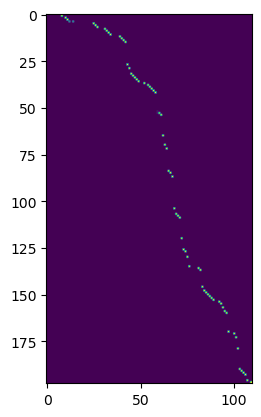

In [16]:
plt.imshow(P)

In [25]:
#np.argmax(all_lolscores, axis = 0)
#alignments["lolscore_anchor"] = np.max(all_lolscores, axis = 0)
alignments

,Unnamed: 0.1,Unnamed: 0,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,...,qstart_dali,tstart_dali,cigar_dali,dali_rank,lolscore_dali,lolscore_fs,lolscore_lol_fixed,lolscore_lol_lbfgsb,lolscore_lol_lbfgsb_success,lolscore_anchor
0,0,7185,d1bd0a2,d1ykwa1,61,0.3718,8M2D14M1I14M3D6M10D10M8D27M7D6M2D11M2I11M3D21M...,10,7,246,...,2,1,29M2D24M2D4M4D5M1I4M14D5M1I15M6D7M3D7M4I12M6I4...,145,2912.069336,1039.918213,2929.961426,3101.256991,True,3071.246826
1,1,9019,d1bm9a_,d1ku9a_,39,0.4445,8M2I28M5I10M6I19M,41,46,78,...,1,11,28M2D12M9I26M5I16M13D24M,123,-692.045227,146.618561,560.031433,839.756596,True,834.455627
2,2,11243,d1c4oa1,d1oywa2,50,0.4305,15M5I48M2I11M4I2M21I13M1D6M1I4M71I2M8I8M12I7M2...,8,25,328,...,1,3,4M13D8M2I14M1I46M2I11M25I31M95I6M2D13M7D6M29I9...,9,4486.741699,2997.943848,5632.099609,1889.544731,True,5671.757812
3,3,19877,d1dkza1,d2p06a1,27,0.5078,10M1D8M6D4M1D41M,31,8,71,...,16,1,82M,273,-226.221375,-7.789455,252.211395,439.874062,True,399.331787
4,4,21931,d1dvoa_,d1s35a1,13,0.3393,13M4D11M2I13M2D17M3I9M17I14M3I10M,39,2,118,...,1,14,41M51I5M2I5M1D4M13I31M,48,137.838470,-892.626770,-49.812542,331.485053,True,283.349335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,344737,d3irua_,d2w43a_,98,0.4652,13M7D16M13I13M6I9M3I11M8I3M1I9M2I32M1I31M3I25M...,14,2,264,...,13,1,16M3D7M22D11M48I14M1I7M1I8M1I11M3I13M2D30M3I27...,44,4616.894043,3447.175537,5635.312500,5836.913727,True,5285.364746
96,96,349671,d3m94a_,d1sc6a3,42,0.3697,13M10I5M1I27M2I18M3I2M2I9M,76,11,92,...,54,1,4M7I5M5I9M7I4M2I7M2I30M2I18M3I7M,24,1277.434814,682.383057,1455.606812,1478.339325,True,1046.984131
97,97,349849,d3ma2b_,d1n9wa1,33,0.3625,9M1D11M2I10M1D2M6I8M8I15M6D3M1D3M4D9M,12,9,99,...,2,1,24M1I5M2I10M5I9M6I4M1I4M1I11M7D5M3I7M11I7M,37,762.580078,102.951736,1207.911133,1017.300759,True,996.043640
98,98,359460,d3t0ha_,d2hkja3,123,0.4256,4M4D11M1D16M1I2M12I10M3D5M2D23M11I7M2D12M4D7M1...,12,4,223,...,12,1,10M1D5M7D19M13I12M5D21M4I11M5I20M5D11M1D9M5D4M...,5,4263.217773,2510.592285,4352.616211,4548.853023,True,4347.911621


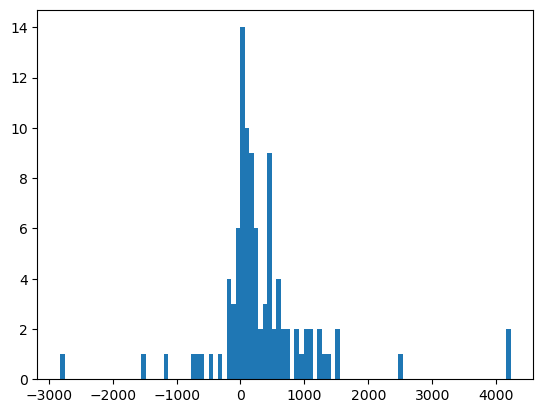

In [33]:
plt.hist((np.max(all_lolscores_kl, axis = 0) - alignments['lolscore_dali']), bins=100)
#plt.xlable("LoL_score Anchor with autofiff - lol_score dali")
a=0

In [35]:
np.argmin(np.max(all_lolscores_kl, axis = 0) - alignments['lolscore_dali'])

83

In [26]:
print((np.argmax(all_lolscores_kl, axis = 0)))

[2 0 2 0 0 8 0 5 3 4 2 0 1 2 1 0 4 0 1 0 6 0 0 6 4 1 0 7 1 1 1 1 3 2 0 2 1
 9 2 1 0 0 2 4 2 2 1 4 2 3 0 9 3 0 6 7 6 2 2 0 0 1 6 1 0 2 0 1 3 0 4 1 2 8
 0 2 0 2 6 9 4 1 8 4 6 3 0 8 0 0 0 9 0 0 0 0 6 3 3 2]


In [20]:
all_lolscores_kl[:,37]

array([414.89736938, 617.04180908, 364.0355835 , 572.33728027,
       575.17584229, 419.93731689, 499.98928833, 560.95581055,
       431.0559082 , 634.5526123 ])

In [29]:
plt.hist((all_lolscores_fixed - alignments['lolscore_lol_fixed']), bins=50)
(all_lolscores_fixed - alignments['lolscore_lol_fixed'])

NameError: name 'all_lolscores_fixed' is not defined

In [37]:
alignments[83:]

,Unnamed: 0.1,Unnamed: 0,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,...,qstart_dali,tstart_dali,cigar_dali,dali_rank,lolscore_dali,lolscore_fs,lolscore_lol_fixed,lolscore_lol_lbfgsb,lolscore_lol_lbfgsb_success,lolscore_anchor
83,83,295131,d2oula_,d2cb5a_,114,0.3995,4M2I12M5I34M1D8M16D15M5D3M7D8M1D9M2D5M24D5M17D...,6,43,401,...,1,33,24M3I4M1D30M1D14M30D20M1I10M3D4M48D10M19D4M8D7...,10,9684.892578,2521.717529,4363.944824,6284.549916,True,4154.291016
84,84,302849,d2q4xa_,d2a2ma1,127,0.4976,12M5D6M13I30M3I8M1I9M3I13M1D23M1I21M3I8M1D10M1...,1,36,221,...,1,28,19M1D5M1I36M2I4M2I24M2I26M1I30M1I14M2I18M3I25M,11,5000.785156,2522.374512,5006.830078,4599.416271,True,4386.948730
85,85,305429,d2qrwa_,d2nrla_,26,0.3897,9M6D5M9D11M1D3M12D15M1D4M1D5M5I8M1D23M2I6M3D14M,12,2,144,...,1,3,8M2I4M4D12M1D11M12D18M2I17M1D23M2I23M5D4M,25,1261.892822,-173.678223,886.109802,1037.315224,False,987.380249
86,86,308012,d2rh3a1,d2rh3a1,949,1.0000,121M,1,1,121,...,1,1,121M,1,4890.865234,4890.865234,4890.865234,4891.002112,True,4890.865234
87,87,309787,d2uy2a_,d1goia2,172,0.4200,9M3D9M8D5M2D27M3I4M6I12M5D10M4D6M7D12M3D4M3I3M...,1,1,375,...,1,1,11M12D8M1I6M2D11M1I4M3D4M10I5M2D15M2D11M8D4M3D...,10,9359.685547,4682.319336,8009.308594,6936.931565,True,7221.283691
88,88,322496,d3afma_,d1h5qa_,653,0.7262,37M1I10M1D41M1I34M4I21M7D3M1I83M1I13M,5,7,258,...,1,3,41M2D4M1D8M3I40M1I35M2D4M6I15M6D81M1I19M,22,11030.341797,9976.933594,11046.220703,11339.562338,True,10885.348633
89,89,322902,d3akea_,d2qora_,52,0.3222,31M12I8D7M7D11M2D6M3I5M4I5M5I9M19I9M1D10M3D6M3...,3,5,229,...,1,3,27M2D4M2I6M13D5M12I10M24I11M7I5M1D5M4D16M5D10M...,37,2853.584229,-95.928497,2793.715820,3107.724226,True,3121.028320
90,90,329090,d3cb0a_,d3cb0a_,1500,1.0000,166M,1,1,166,...,1,1,166M,1,8215.291016,8215.291016,8215.291016,8214.954063,True,8215.291016
91,91,334430,d3dxoa1,d3dmca1,139,0.6070,6M4D16M4I14M4D20M1D25M1D6M1D11M1I12M,3,8,126,...,1,10,18M4I19M4D26M1D21M2D16M1I12M,34,2317.243408,2033.453125,2278.307617,2279.936245,True,2274.228027
92,92,336527,d3emca_,d1tg7a5,131,0.4147,6M8D18M2D8M4I16M3D14M1D3M6I11M8D3M3D17M2D3M5D1...,15,20,365,...,1,7,23M6D13M1D7M2I15M3D24M6D9M5I4M5D22M7D14M2D5M9I...,29,7741.523438,4372.590820,8255.762695,8603.778103,True,7504.042969


In [30]:
alignments[alignments['lolscore_dali'] - np.max(all_lolscores, axis = 0) < 0]

,Unnamed: 0.1,Unnamed: 0,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,...,qstart_dali,tstart_dali,cigar_dali,dali_rank,lolscore_dali,lolscore_fs,lolscore_lol_fixed,lolscore_lol_lbfgsb,lolscore_lol_lbfgsb_success,lolscore_anchor
0,0,7185,d1bd0a2,d1ykwa1,61,0.3718,8M2D14M1I14M3D6M10D10M8D27M7D6M2D11M2I11M3D21M...,10,7,246,...,2,1,29M2D24M2D4M4D5M1I4M14D5M1I15M6D7M3D7M4I12M6I4...,145,2912.069336,1039.918213,2929.961426,3101.256991,True,3536.241699
1,1,9019,d1bm9a_,d1ku9a_,39,0.4445,8M2I28M5I10M6I19M,41,46,78,...,1,11,28M2D12M9I26M5I16M13D24M,123,-692.045227,146.618561,560.031433,839.756596,True,718.652100
3,3,19877,d1dkza1,d2p06a1,27,0.5078,10M1D8M6D4M1D41M,31,8,71,...,16,1,82M,273,-226.221375,-7.789455,252.211395,439.874062,True,379.324524
4,4,21931,d1dvoa_,d1s35a1,13,0.3393,13M4D11M2I13M2D17M3I9M17I14M3I10M,39,2,118,...,1,14,41M51I5M2I5M1D4M13I31M,48,137.838470,-892.626770,-49.812542,331.485053,True,172.692825
6,6,30644,d1eyva_,d1tzva_,277,0.7764,18M1D8M6I10M2D88M,1,4,133,...,1,4,20M1D11M7I5M3D88M,2,3500.263672,3319.957520,3547.009033,3551.856729,True,3514.493164
9,9,48669,d1h6ka2,d3gvoa_,32,0.3679,10M2D11M7I25M4I33M2D9M8D9M5D30M10D7M1I3M5D14M,24,130,195,...,27,1,12M3I6M10I10M8I34M9I17M7D11M8I5M1D7M5I7M4D7M15D5M,450,596.429932,-996.622803,-405.377747,-28.428558,False,815.474243
11,11,59158,d1iq0a3,d3eera_,18,0.2681,17M5D15M1I3M,3,54,41,...,1,52,21M1D5M9D13M1I4M6I10M1D9M12I6M1D9M,82,324.637299,-222.957016,538.487793,-235.199651,False,664.189453
13,13,68959,d1jnra1,d1oe8a1,29,0.3987,16M3D7M3I9M5D10M6D8M4I20M,12,11,91,...,6,1,23M12D28M6I9M2I20M9I21M8I10M,432,236.273483,267.603607,571.867859,785.387516,True,787.077881
14,14,79137,d1ktba1,d1wzaa1,65,0.5060,4M1I15M1I9M1I11M7I9M1I28M,4,2,87,...,3,1,7M1I13M1I12M1I8M10I8M2D29M,19,1140.906128,829.695068,1320.876221,1336.764655,True,1288.297974
15,15,79528,d1kv9a1,d1gu2a_,16,0.4064,5M1I5M11D9M6D5M1D4M5I3M3D6M3I15M4D16M,20,28,102,...,8,1,4M15D18M10D10M1D4M6D7M5D4M3D11M9I22M4I4M,34,842.805786,304.550140,861.877808,781.830218,True,1015.828247


In [40]:
alignments['lolscore_dali'] - alignments['lolscore_anchor']

0     -159.177490
1    -1526.500854
2    -1185.016113
3     -625.553162
4     -145.510864
         ...     
95    -668.470703
96     230.450684
97    -233.463562
98     -84.693848
99      -6.897827
Length: 100, dtype: float64

In [56]:
d_mat_ij.shape

(196, 196)

In [54]:
index_temp

array([[  0],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
       [ 71],
       [ 72],
       [ 73],
       [ 74],
       [ 75],
       [ 76],
       [ 77],
       [ 78],
       [ 79],
       [ 80],
       [ 81],
       [ 82],
       [ 83],
       [ 84],
       [ 85],
       [ 86],
       [ 87],
       [ 88],
       [ 89],
       [ 90],
       [ 91],
       [ 92],
       [ 93],
       [ 94],
       [ 95],
       [ 96],
       [ 97],
       [ 98],
       [ 99],
       [100],
       [101],
       [102],
       [103],
       [104],
       [105],
       [106],
       [107],
       [108],
       [109],
       [110],
       [111],
       [112],
      

In [63]:
P = dali
th = 0.9
d_mat_ij[d_mat_ij > 15] = 0
th = 0.75
index_test = (np.argwhere(np.sum(P > th,axis = 1) != 0).reshape(-1)[None,:] - np.argwhere(np.sum(P > th,axis = 1) != 0).reshape(-1)[:,None])

np.sum(np.sum(P > th,axis = 0) == 0)#.shape
index_temp = np.argwhere(np.sum(P > th,axis = 1) == 0)
d_mat_ij_test = np.delete(d_mat_ij, index_temp, axis = 0)
d_mat_ij_test = np.delete(d_mat_ij_test, index_temp, axis = 1)

index_temp = np.argwhere(np.sum(P > th,axis = 0) == 0)

d_mat_kl_test = np.delete(d_mat_kl, index_temp, axis = 0)
d_mat_kl_test = np.delete(d_mat_kl_test, index_temp, axis = 1)

d_mask_test = d_mat_ij_test > 0

d_ij_test, d_kl_test, d_seq_test = d_mat_ij_test[d_mask_test], d_mat_kl_test[d_mask_test], index_test[d_mask_test]
_lol_scores = lol_score_jax(d_ij_test, d_kl_test, d_seq_test)
#all_lolscores_fixed[j] = np.sum(_lol_scores)
print(np.sum(_lol_scores))

9202.12


In [41]:
_lol_scores = lol_score_jax(d_ij_test, d_kl_test, d_seq_test)
print(np.sum(_lol_scores))

507.3331


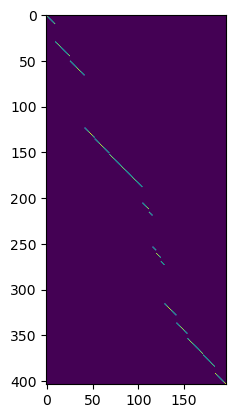

In [45]:
plt.imshow(P>=1)

In [23]:
scope_gt = [0.94014, 0.705368, 0.450493]
scope_fs = [0.881832, 0.461209, 0.112823]
scope_lol = [0.262383, 0.111535, 0.0294053]
scope_rescale = [0.87915, 0.483263, 0.113512]
scope_lol3di = [0.892423, 0.520494, 0.138355]
names = ["scope_gt", "scope_fs", "scope_lol", "scope_rescale", "scope_lol3di"]

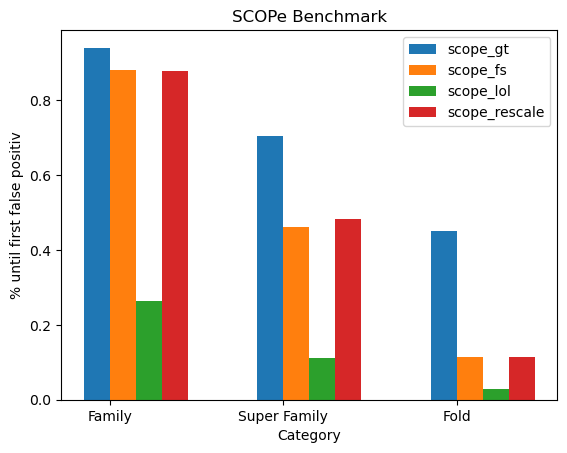

In [25]:
data = np.array([scope_gt, scope_fs, scope_lol, scope_rescale, scope_lol3di])
num_groups = len(data[0])
# Creating a figure and axis for the plot
fig, ax = plt.subplots()

# Setting the positions and width for the bars
positions = np.arange(num_groups)
width = 0.15  # Adjust this for the width of the bars

# Plotting the data
for i in range(4):
    ax.bar(positions - width/2. + i*width, data[i], width, label=names[i])

# Adding some features to make the plot readable
ax.set_xlabel('Category')
ax.set_ylabel('% until first false positiv')
ax.set_title('SCOPe Benchmark')
ax.set_xticks(positions)
ax.set_xticklabels(['Family', 'Super Family', 'Fold'])  # Assuming these are the categories
ax.legend()

# Display the plot
plt.show()

In [35]:
scope_gt = [0.94014, 0.705368, 0.450493]
scope_fs = [0.91582, 0.556923, 0.193143]
scope_lol = [0.442568, 0.229791, 0.076448]
scope_rescale = [0.903566, 0.573916, 0.198993]
scope_lol3di = [0.904009, 0.606844, 0.220614]
names = ["scope_gt", "scope_fs", "scope_lol", "scope_rescale", "scope_lol3di"]

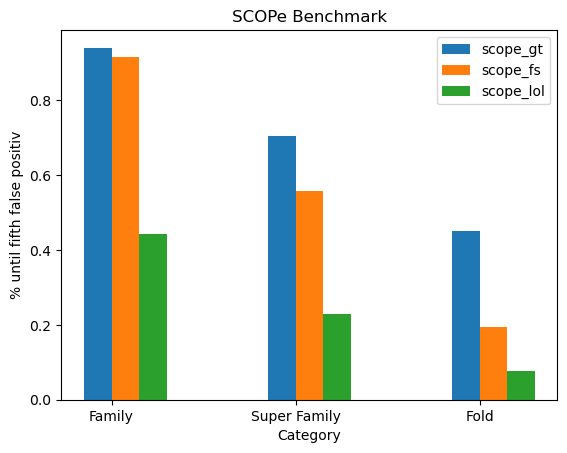

In [38]:
data = np.array([scope_gt, scope_fs, scope_lol, scope_rescale, scope_lol3di])
num_groups = len(data[0])
# Creating a figure and axis for the plot
fig, ax = plt.subplots()

# Setting the positions and width for the bars
positions = np.arange(num_groups)
width = 0.15  # Adjust this for the width of the bars

# Plotting the data
for i in range(3):
    ax.bar(positions - width/2. + i*width, data[i], width, label=names[i])

# Adding some features to make the plot readable
ax.set_xlabel('Category')
ax.set_ylabel('% until fifth false positiv')
ax.set_title('SCOPe Benchmark')
ax.set_xticks(positions)
ax.set_xticklabels(['Family', 'Super Family', 'Fold'])  # Assuming these are the categories
ax.legend()

# Display the plot
plt.show()